import torch

Net(
  (hidden): Linear(in_features=1, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
)


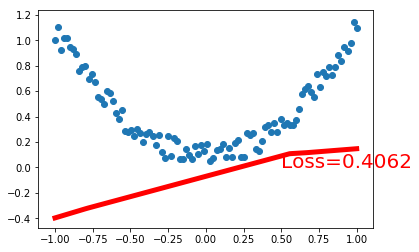

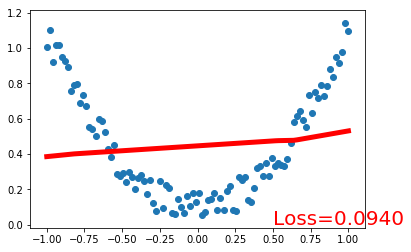

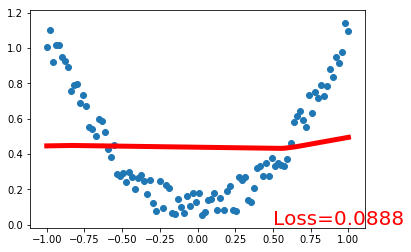

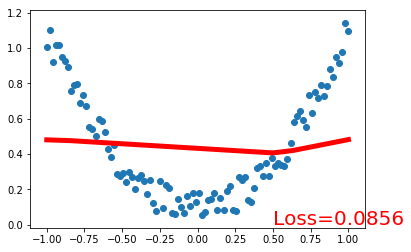

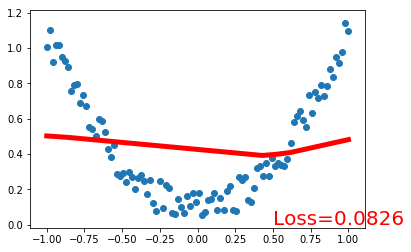

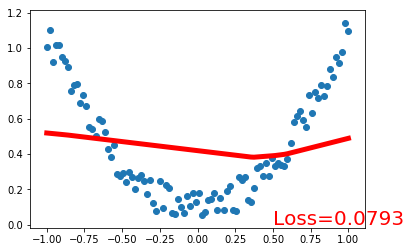

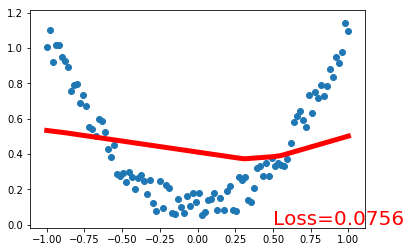

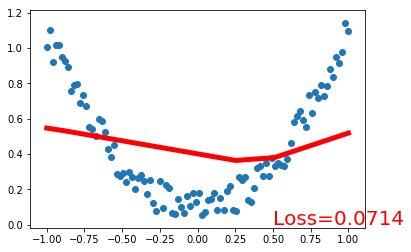

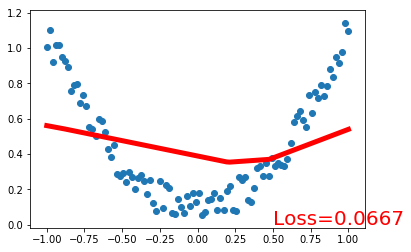

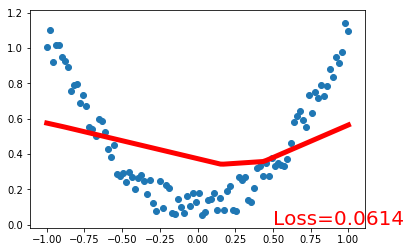

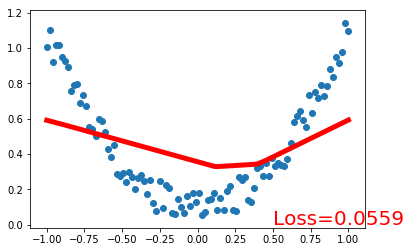

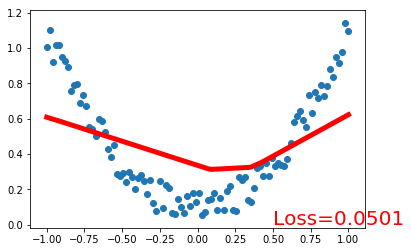

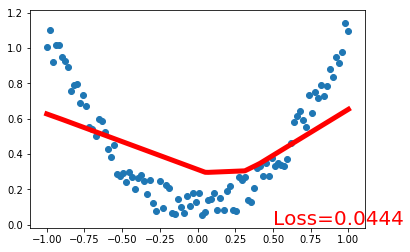

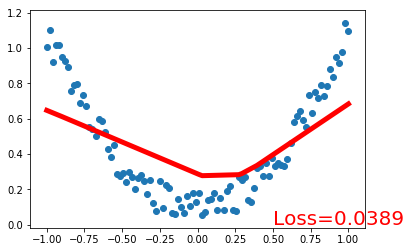

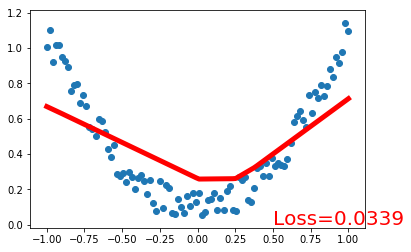

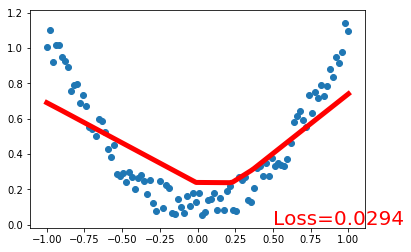

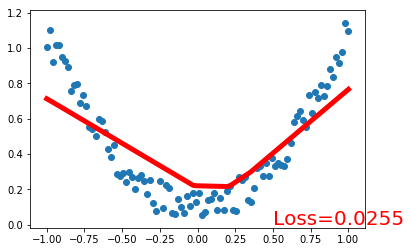

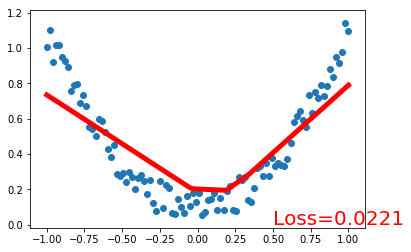

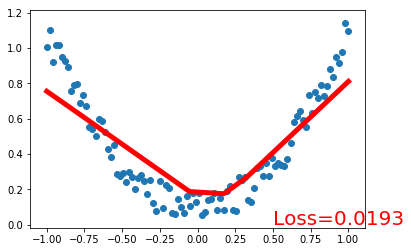

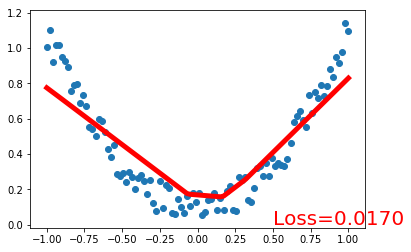

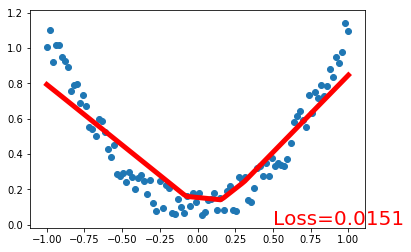

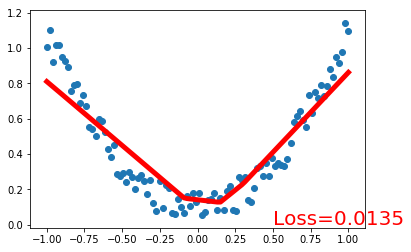

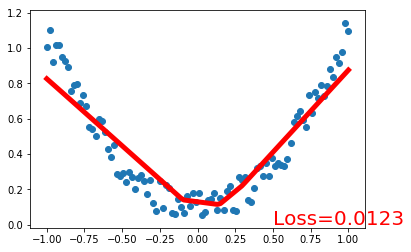

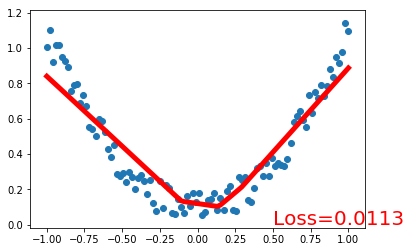

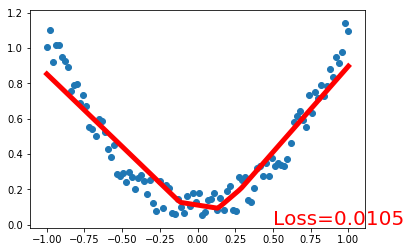

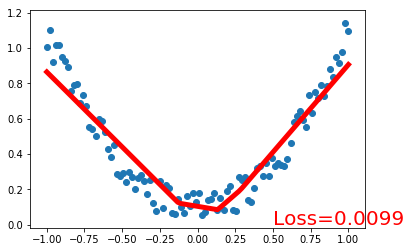

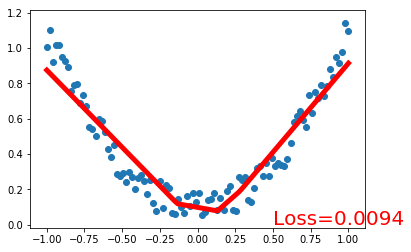

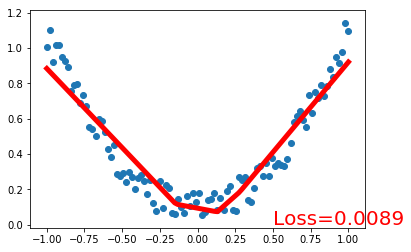

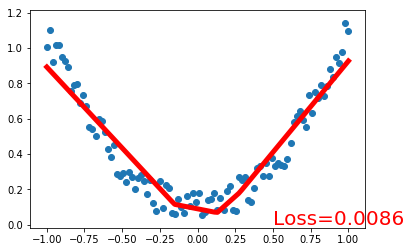

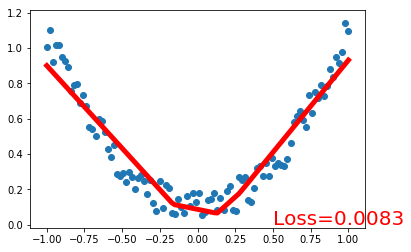

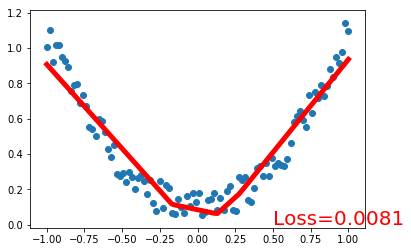

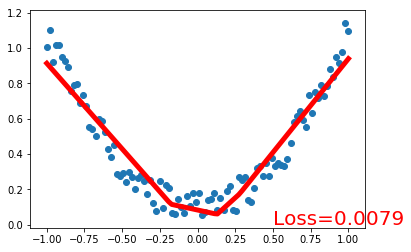

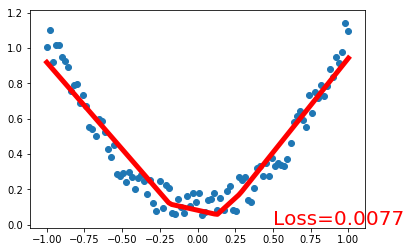

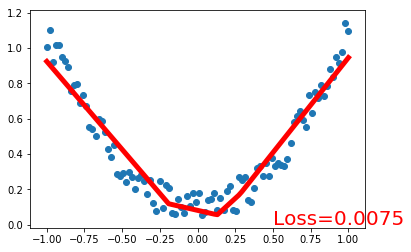

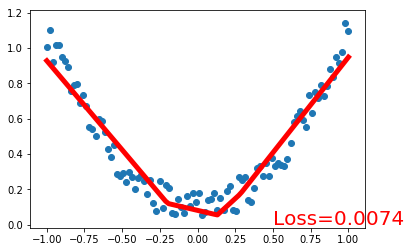

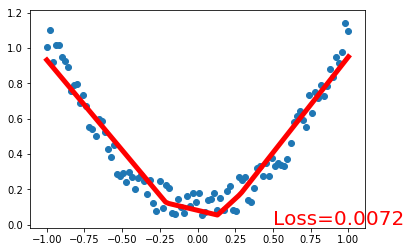

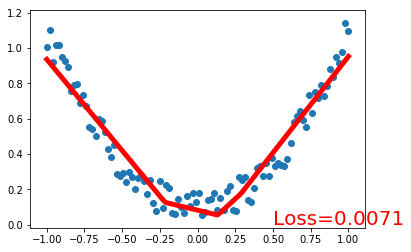

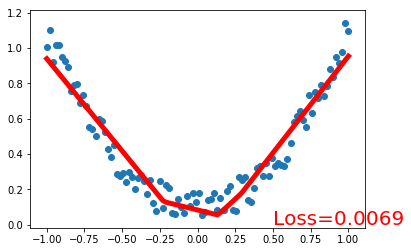

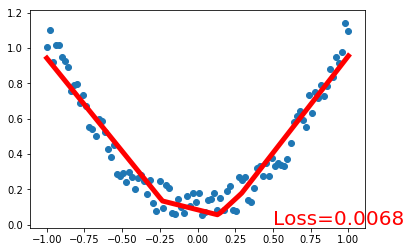

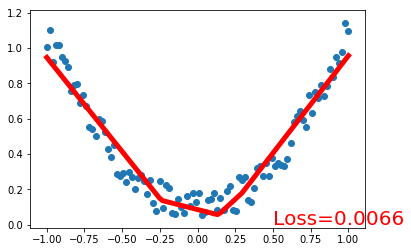

In [24]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# torch.manual_seed(1)    # reproducible

x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  # x data (tensor), shape=(100, 1)
y = x.pow(2) + 0.2*torch.rand(x.size())                 # noisy y data (tensor), shape=(100, 1)

# torch can only train on Variable, so convert them to Variable
# The code below is deprecated in Pytorch 0.4. Now, autograd directly supports tensors
# x, y = Variable(x), Variable(y)

# plt.scatter(x.data.numpy(), y.data.numpy())
# plt.show()


class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

net = Net(n_feature=1, n_hidden=10, n_output=1)     # define the network
print(net)  # net architecture

optimizer = torch.optim.SGD(net.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

plt.ion()   # something about plotting

for t in range(200):
    prediction = net(x)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients

    if t % 5 == 0:
        # plot and show learning process
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.plot(x.data.numpy(), prediction.data.numpy(), 'r-', lw=5)
        plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.pause(0.1)

plt.ioff()
plt.show()

In [25]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [26]:
class DQN(nn.Module):

    def __init__(self, h, w):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, 2) # 448 or 512

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [23]:
 \criterion = nn.MSELoss()
